In [20]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate sample data
num_customers = 1000
num_purchases = 10000
start_date = datetime(2021, 1, 1)
end_date = datetime(2023, 12, 31)

In [ ]:
# Generate customer IDs
customer_ids = np.arange(1, num_customers + 1)


In [ ]:
# Generate purchase data
purchase_data = []
for _ in range(num_purchases):
    customer_id = np.random.choice(customer_ids)
    purchase_date = start_date + timedelta(days=np.random.randint(0, (end_date - start_date).days))
    purchase_amount = np.random.uniform(10, 500)  # Random amount between $10 and $500
    product_category = np.random.choice(['Electronics', 'Clothing', 'Home & Garden', 'Books', 'Sports'])
    
    purchase_data.append([customer_id, purchase_date, purchase_amount, product_category])


In [ ]:
# Create DataFrame
df = pd.DataFrame(purchase_data, columns=['customer_id', 'purchase_date', 'purchase_amount', 'product_category'])


In [ ]:
# Sort by customer_id and purchase_date
df = df.sort_values(['customer_id', 'purchase_date'])



In [ ]:
# Save to CSV
df.to_csv('clv_sample_dataset.csv', index=False)


In [ ]:
print(df.head())
print(f"\nDataset shape: {df.shape}")
print(f"\nUnique customers: {df['customer_id'].nunique()}")
print(f"\nDate range: {df['purchase_date'].min()} to {df['purchase_date'].max()}")

In [ ]:
# Assume a discount rate of 10%
discount_rate = 0.10

# Calculate CLV for each customer
df['CLV'] = df['purchase_amount'] / (1 + discount_rate) ** (df.index + 1)

# Sum CLV for all customers
total_clv = df['CLV'].sum()
print(f'Total Customer Lifetime Value: ${total_clv:.2f}')

In [ ]:
df = pd.read_csv('clv_sample_dataset.csv')
df['purchase_date'] = pd.to_datetime(df['purchase_date'])
df

In [17]:
def calculate_clv(df):
    # 1. Customer Lifespan
    customer_lifespan = df.groupby('customer_id').agg({
        'purchase_date': lambda x: (x.max() - x.min()).days / 365
    }).reset_index()
    customer_lifespan.columns = ['customer_id', 'lifespan_years']
    
    # 2. Purchase Frequency (purchases per year)
    purchase_frequency = df.groupby('customer_id').size().reset_index(name='purchase_count')
    purchase_frequency = purchase_frequency.merge(customer_lifespan, on='customer_id')
    purchase_frequency['frequency'] = purchase_frequency['purchase_count'] / purchase_frequency['lifespan_years']
    purchase_frequency = purchase_frequency[['customer_id', 'frequency']]
    
    # 3. Average Purchase Value
    avg_purchase_value = df.groupby('customer_id')['purchase_amount'].mean().reset_index()
    avg_purchase_value.columns = ['customer_id', 'avg_purchase_value']
    
    # Combine all components
    clv_df = customer_lifespan.merge(purchase_frequency, on='customer_id')
    clv_df = clv_df.merge(avg_purchase_value, on='customer_id')
    
    # Calculate CLV
    clv_df['clv'] = clv_df['lifespan_years'] * clv_df['frequency'] * clv_df['avg_purchase_value']
    
    return clv_df

In [18]:
# Calculate CLV
clv_results = calculate_clv(df)

# Display summary statistics
print(clv_results.describe())


       customer_id  lifespan_years    frequency  avg_purchase_value  \
count  1000.000000     1000.000000  1000.000000         1000.000000   
mean    500.500000        2.393101     4.251407          254.946719   
std     288.819436        0.446927     1.827175           47.997738   
min       1.000000        0.065753     1.046845           68.088000   
25%     250.750000        2.198630     3.338097          223.067392   
50%     500.500000        2.501370     4.113030          252.721438   
75%     750.250000        2.712329     4.902748          287.783668   
max    1000.000000        2.983562    45.625000          406.917961   

               clv  
count  1000.000000  
mean   2558.751205  
std     986.181901  
min     182.475607  
25%    1835.773575  
50%    2480.316270  
75%    3173.296652  
max    6789.693729  


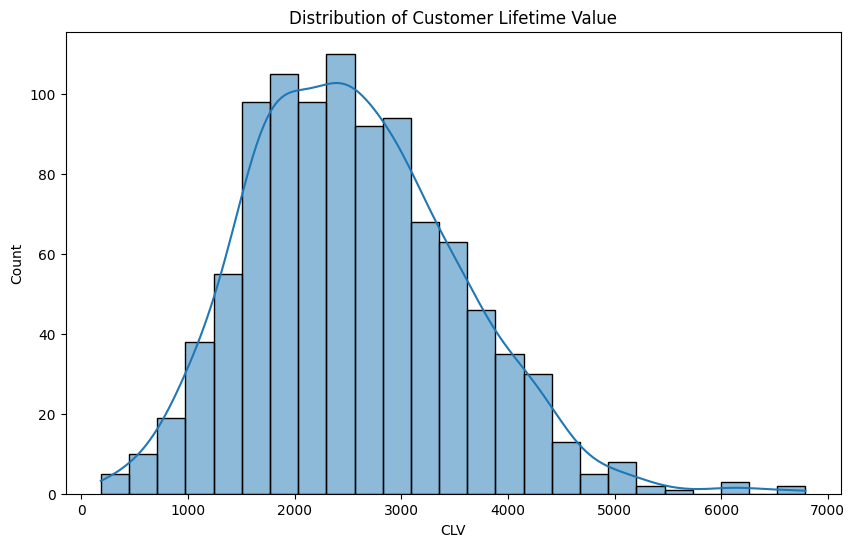

In [21]:
# Visualize CLV distribution
plt.figure(figsize=(10, 6))
sns.histplot(clv_results['clv'], kde=True)
plt.title('Distribution of Customer Lifetime Value')
plt.xlabel('CLV')
plt.ylabel('Count')
plt.show()


In [22]:
# Identify top 10% of customers by CLV
top_customers = clv_results.nlargest(int(len(clv_results) * 0.1), 'clv')
print("\nTop 10% of customers by CLV:")
print(top_customers)


Top 10% of customers by CLV:
     customer_id  lifespan_years  frequency  avg_purchase_value          clv
15            16        2.449315   8.165548          339.484686  6789.693729
380          381        2.821918   7.441748          312.592543  6564.443395
818          819        2.865753   6.978967          307.826989  6156.539788
208          209        2.964384   6.746765          307.030647  6140.612938
972          973        2.030137   9.358974          321.826675  6114.706822
..           ...             ...        ...                 ...          ...
634          635        2.676712   4.483112          327.549392  3930.592705
395          396        1.958904   5.615385          355.918119  3915.099308
338          339        2.701370   4.812373          300.513084  3906.670090
529          530        1.997260   6.508916          300.175371  3902.279823
342          343        2.936986   5.788246          227.383850  3865.525447

[100 rows x 5 columns]


In [23]:
# Analyze CLV by product category
category_clv = df.merge(clv_results[['customer_id', 'clv']], on='customer_id')
category_clv = category_clv.groupby('product_category')['clv'].mean().sort_values(ascending=False)
print("\nAverage CLV by product category:")
print(category_clv)


Average CLV by product category:
product_category
Clothing         2878.171616
Books            2874.205366
Sports           2848.951314
Electronics      2830.612964
Home & Garden    2814.108198
Name: clv, dtype: float64


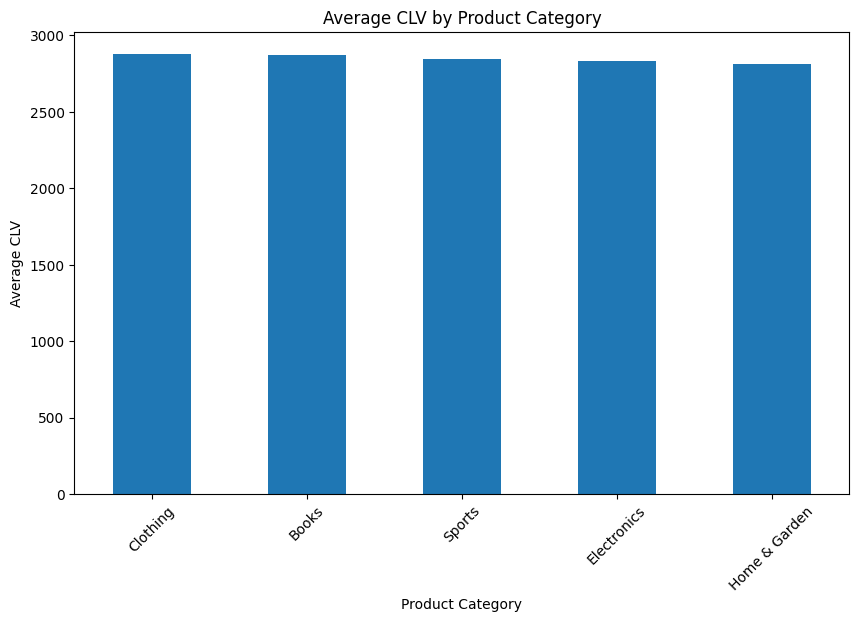

In [24]:

# Visualize CLV by product category
plt.figure(figsize=(10, 6))
category_clv.plot(kind='bar')
plt.title('Average CLV by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Average CLV')
plt.xticks(rotation=45)
plt.show()